In [2]:
import sys
sys.path.append("./cls")

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np

from cls.data_ij import ModelNet40
from util import cal_loss
# from PointMixup.emd_ import emd_module
from injae.partseg.PointMixup.emd_ import emd_module
EMD = emd_module.emdModule()

modelnet_test = ModelNet40(partition='test', num_points=2048)

device = torch.device("cuda")

def get_pc(class_num, dataset=modelnet_test, idx=None, num_points=1024):
    if idx==None:
        class_idx = np.where(dataset.label[:]==class_num)[0]
        idx = np.random.choice(class_idx)
    pc = dataset.data[idx]
    return pc[:num_points], idx

def get_pc_batch(class_1, class_2, batch_size=16, dataset=modelnet_test, idx_list=None, num_points=1024):
    A = []
    B = []
    if idx_list is None:
        A_idx_list = []
        B_idx_list = []
        for i in range(batch_size):
            a, a_idx = get_pc(class_1, dataset=dataset, idx=None, num_points=num_points)
            b, b_idx = get_pc(class_2, dataset=dataset, idx=None, num_points=num_points)
            A.append(a)
            B.append(b)
            A_idx_list.append(a_idx)
            B_idx_list.append(b_idx)
        idx_list = (A_idx_list, B_idx_list)
    else:
        for i, j in zip(*idx_list):
            a, _ = get_pc(class_1, dataset=dataset, idx=i, num_points=num_points)
            b, _ = get_pc(class_2, dataset=dataset, idx=j, num_points=num_points)
            A.append(a)
            B.append(b)
    A = np.stack(A)
    B = np.stack(B)
    return torch.from_numpy(A), torch.from_numpy(B), idx_list

## Aug Codes

### PointMixup

In [3]:
def mixup(xyz1, xyz2, mixrate):
    """
    Args:
        xyz (B,N,3): 
        label (B): 
        x (B,D,N): Defaults to None.
        saliency (B,N): Defaults to None.
    """        

    _, ass = EMD(xyz1, xyz2, 0.005, 5000) # mapping
    ass = ass.long()
    xyz2_new = torch.zeros_like(xyz2).to(xyz1.device)

    for i in range(batch_size):
        xyz2_new[i] = xyz2[i][ass[i]]
    
    mix = xyz1*(1-mixrate) + xyz2_new*(mixrate)


    return mix

### RSMix

In [4]:
from injae.rsmix import rsmix

### Ours

In [5]:
def ours(xyz, perm, alpha=None, anchor=None, x=None, saliency=None, num_points=1024, sigma=0.1, beta=None, saliency_ver=0):
    """
    Args:
        xyz (B,N,3): 
        label (B): 
        x (B,D,N): Defaults to None.
        saliency (B,N): Defaults to None.
    """        


    _, ass = EMD(xyz, perm, 0.005, 10000) # mapping
    ass = ass.long()
    perm_new = torch.zeros_like(perm).to(perm.device)

    for i in range(batch_size):
        perm_new[i] = perm[i][ass[i]]

    if anchor is not None:
        anchor_ori, anchor_perm = xyz[torch.arange(len(xyz)),anchor[0],:], perm[torch.arange(len(perm)),anchor[1], :]
    #random_sampling
    elif saliency is None:
        anc_idx = torch.randperm(num_points)[:2]
        anchor_ori, anchor_perm = xyz[:,anc_idx[0],:], perm_new[:,anc_idx[1], :]
    #weighted sampling
    elif saliency_ver == 1:
        anc_idx = torch.multinomial(saliency, 2, replacement=True)
        anchor_ori = xyz[torch.arange(batch_size),anc_idx[:,0]]
        anchor_perm = xyz[torch.arange(batch_size),anc_idx[:,1]][idxs]
    #max
    elif saliency_ver == 2:
        anc_idx = saliency.max(1)[1]
        anchor_ori = xyz[torch.arange(batch_size),anc_idx]
        anchor_perm = anchor_ori[idxs]

    if beta is not None:
        alpha = beta.sample((batch_size,)).to([perm.device])
    elif alpha is not None:
        alpha = alpha
    else:
        alpha = 0.5

    sub_ori = xyz - anchor_ori[:,None,:]
    sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
    weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)
    weight_ori = weight_ori * alpha

    sub_perm = perm_new - anchor_perm[:,None,:]
    sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
    weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma ** 2))  #(M,N)
    weight_perm = weight_perm * (1-alpha)

    weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1)) + 1e-16
    weight = weight/weight.sum(-1)[...,None]

    #mixup sampe
    if x is None:
        x = xyz
        perm_x_new = perm_new
    else:
        x = x.permute(0,2,1)
        perm_x = x[idxs]
        perm_x_new = torch.zeros_like(perm_x).cuda()
        for i in range(batch_size):
            perm_x_new[i] = perm_x[i][ass[i]]

    x = weight[:,:,0:1] * x + weight[:,:,1:] * perm_x_new
#     x = x.permute(0,2,1)


    return x, {"mix" : x, "perm" : perm_new, "weight":weight}

## Prepare viz

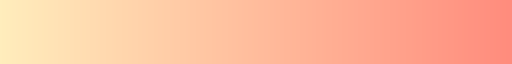

In [6]:
import pyvista as pv
import numpy as np

def get_shadow(plotter, pos, point_size, scale=3, origin=None, opacitiy=0.1, color= "#dddddd"):
    #pos (n,3)
    pos  =pos.repeat(scale, 0) 
    pos +=  np.random.rand(pos.shape[0],pos.shape[1])/20

    point_cloud = pv.PolyData(pos)

    if origin is None:
        origin = [0,0,pos[:,2].min() - 0.05]
    point_cloud = point_cloud.project_points_to_plane(origin=origin, normal=[0,0,-1])

    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True,\
                        opacity=opacitiy, color = color, lighting=False) 


pv.start_xvfb()
from matplotlib.colors import ListedColormap
s_color = np.array([255, 237, 188, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)

color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
cmap = ListedColormap(color_map.transpose((1,0)))
cmap

In [7]:
def visualize_batch(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, index=None):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()
    
    if index==None:
        index = range(len(aug))

    for i in index:
        plotter = pv.Plotter(notebook=True, shape=(1,3))
            
        plotter.subplot(0, 0)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(A[i][:,[0,2,1]])
        # point_cloud['y'] = np.zeros(len(A[i]))
        point_cloud['y'] = A_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, A[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 1)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(aug[i][:,[0,2,1]])
        point_cloud['y'] = aug_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, aug[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 2)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(B[i][:,[0,2,1]])
        # point_cloud['y'] = np.ones(len(B[i]))
        point_cloud['y'] = B_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, B[i][:,[0,2,1]], point_size)

#         light = pv.Light(intensity=0.15, shadow_attenuation = 0)
        light = pv.Light(intensity=0.20, shadow_attenuation = 0)
        light.set_direction_angle(30,0)
        plotter.add_light(light)
#         light = pv.Light(intensity=0.12, shadow_attenuation = 0)
        light = pv.Light(intensity=0.16, shadow_attenuation = 0)
        light.set_direction_angle(30,180)
        plotter.add_light(light)

        plotter.show()
    return plotter
    
def save_pdf(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, filename):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()

    plotter = pv.Plotter(notebook=True, shape=(1,3))

    plotter.subplot(0, 0)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(A[:,[0,2,1]])
    # point_cloud['y'] = np.zeros(len(A[i]))
    point_cloud['y'] = A_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, A[:,[0,2,1]], point_size)

    plotter.subplot(0, 1)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(aug[:,[0,2,1]])
    point_cloud['y'] = aug_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, aug[:,[0,2,1]], point_size)

    plotter.subplot(0, 2)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(B[:,[0,2,1]])
    # point_cloud['y'] = np.ones(len(B[i]))
    point_cloud['y'] = B_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, B[:,[0,2,1]], point_size)

    light = pv.Light(intensity=0.15, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)

    plotter.save_graphic(filename)


In [8]:
camera_pos = [1,-1,1]#,[0,0,1]]
point_size = 7

## VIZ

In [9]:
batch_size = 16
num_points = 1024
point_size = 9
camera_pos = camera_pos
class_1 = 17
class_2 = 8

# A, B, idx_list = get_pc_batch(class_1, class_2, batch_size, num_points=num_points)

idx_list = [[282]*batch_size, [1807]*batch_size]
A, B, idx_list = get_pc_batch(class_1, class_2, batch_size, idx_list=idx_list, num_points=num_points)

### mixup

In [10]:
mixrate = 0.55
aug = mixup(A, B, mixrate)
A_weight = np.zeros(A.shape[:2])
B_weight = np.ones(B.shape[:2])
aug_weight = np.zeros((len(aug),len(A[0])))+mixrate
visualize_batch(A, B, aug, cmap, point_size=point_size, camera_position=camera_pos,
                A_weight=A_weight, B_weight=B_weight, aug_weight=aug_weight, 
                index=[-1])

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [11]:
filename = './injae/cutmix_0.55.pdf'
idx = -1
save_pdf(A[idx], B[idx], aug[idx], cmap, point_size=point_size, camera_position=camera_pos,
                A_weight=A_weight[idx], B_weight=B_weight[idx], aug_weight=aug_weight[idx], 
                filename=filename)

### RSMix

In [12]:
while True:
    aug, _, erased_num, lam = rsmix(B, A, n_sample=len(A[0])//2, KNN=True)
    # aug, _, erased_num, lam = rsmix(B, A, n_sample=len(A[0])//2, KNN=True)
    if lam[0] < 0.455 and lam[0] > 0.445:
        break
print(lam[0])

# A_weight = np.zeros(A.shape[:2])
# B_weight = np.ones(B.shape[:2])
# aug_weight = np.zeros((len(aug), len(A[0])))
A_weight = np.ones(A.shape[:2])
B_weight = np.zeros(B.shape[:2])
aug_weight = np.ones((len(aug), len(A[0])))
for i in range(len(aug)):
    # aug_weight[i, erased_num[i]:] = 1
    aug_weight[i, erased_num[i]:] = 0
    
visualize_batch(A, B, aug, cmap, point_size=point_size, camera_position=camera_pos,
                A_weight=A_weight, B_weight=B_weight, aug_weight=aug_weight, 
               )
#                 index=[11])

0.451171875


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [13]:
filename = './injae/rsmix_0.55.pdf'
idx = 5
save_pdf(A[idx], B[idx], aug[idx], cmap, point_size=point_size, camera_position=camera_pos,
                A_weight=A_weight[idx], B_weight=B_weight[idx], aug_weight=aug_weight[idx], 
                filename=filename)

### Ours

In [14]:
guitar_idx = 282
chair_idx = 1807

In [15]:
anchor =[]
anchor.append(torch.argmax(A[:,:,0], 1))
anchor.append(torch.argmin(B[:,:,0], 1))
output = ours(A, B, alpha=0.9834, anchor=anchor, sigma=0.3) # sigma=0.4)

aug = output[0]
# B = output[1]['perm']
A_weight = np.zeros(A.shape[:2])
A_weight[np.arange(len(A)), anchor[0]] = 1
B_weight = np.ones(B.shape[:2])
B_weight[np.arange(len(B)), anchor[1]] = 0
aug_weight = output[1]['weight'][:,:,1]
print(torch.mean(aug_weight, 1))
labels = torch.mean((output[1]['weight'][:,:,1])/torch.sum(output[1]['weight'],2),1)
visualize_batch(A, B, aug, cmap, point_size=point_size, camera_position=camera_pos, 
                A_weight=A_weight, B_weight=B_weight, aug_weight=aug_weight, 
#                )
                index=[0])
# visualize_batch(output[1]['perm'], B, aug, cmap, point_size=point_size, camera_position=camera_pos,
#  A_weight=B_weight, B_weight=B_weight, aug_weight=aug_weight, labels=labels)



tensor([0.4500, 0.4509, 0.4503, 0.4501, 0.4507, 0.4502, 0.4500, 0.4502, 0.4509,
        0.4495, 0.4500, 0.4509, 0.4505, 0.4507, 0.4498, 0.4505])


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:
anchor =[]
anchor.append(torch.argmax(A[:,:,0], 1))
anchor.append(torch.argmin(B[:,:,0], 1))
output = ours(A, B, alpha=0.8, anchor=anchor, sigma=0.4)

aug = output[0]
# B = output[1]['perm']
A_weight = np.zeros(A.shape[:2])
A_weight[np.arange(len(A)), anchor[0]] = 1
B_weight = np.ones(B.shape[:2])
B_weight[np.arange(len(B)), anchor[1]] = 0
aug_weight = output[1]['weight'][:,:,1]

labels = torch.mean((output[1]['weight'][:,:,1])/torch.sum(output[1]['weight'],2),1)
visualize_batch(A, B, aug, cmap, point_size=point_size, camera_position=camera_pos, 
                A_weight=A_weight, B_weight=B_weight, aug_weight=aug_weight, 
#                )
                index=[0])
# visualize_batch(output[1]['perm'], B, aug, cmap, point_size=point_size, camera_position=camera_pos,
#  A_weight=B_weight, B_weight=B_weight, aug_weight=aug_weight, labels=labels)


In [53]:
filename = './injae/ours_0.45.pdf'
idx = -1
save_pdf(A[idx], B[idx], aug[idx], cmap, point_size=point_size, camera_position=camera_pos,
                A_weight=A_weight[idx], B_weight=B_weight[idx], aug_weight=aug_weight[idx], 
                filename=filename)

In [10]:
mixup_pick = aug[0]
mixup_weight_pick = aug_weight[0]

In [11]:
rsmix_pick = torch.load("./injae/rsmix_guitar_chair_733.pt")
rsmix_weight_pick = np.zeros(A.shape[1])
rsmix_weight_pick[733:] = 1

In [13]:
ours_pick = aug[3]
ours_weight_pick = aug_weight[3]

In [15]:
new_aug = aug[:3]
new_weight = aug_weight[:3]
new_aug[0] = mixup_pick
new_aug[1] = rsmix_pick
new_aug[2] = ours_pick

new_weight[0] = torch.from_numpy(mixup_weight_pick)
new_weight[1] = torch.from_numpy(rsmix_weight_pick)
new_weight[2] = ours_weight_pick

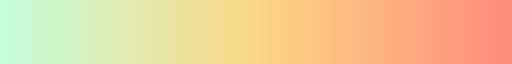

In [16]:
from matplotlib.colors import ListedColormap
s_color = np.array([198, 255, 221, 255])/255
e_color = np.array([251, 215, 134, 255])/255
lin1 = np.linspace(0,1,128)
color_map1 = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin1,0)
s_color = np.array([251, 215, 134, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin2 = np.linspace(0,1,128)
color_map2 = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin2,0)

color_map = np.concatenate([color_map1,color_map2],1)
cmap = ListedColormap(color_map.transpose((1,0)))
cmap

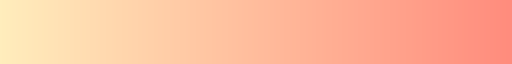

In [21]:
from matplotlib.colors import ListedColormap
s_color = np.array([255, 237, 188, 255])/255
e_color = np.array([255, 140, 125, 255])/255
# e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)

color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
cmap = ListedColormap(color_map.transpose((1,0)))
cmap


In [20]:
plotter = visualize_batch(A, B, new_aug, cmap, point_size=point_size, camera_position=camera_pos,
                A_weight=A_weight[:3], B_weight=B_weight[:3], aug_weight=aug_weight, 
               )

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [21]:
if isinstance(A, torch.Tensor):
    A = A.cpu().numpy()
    B = B.cpu().numpy()
    aug = new_aug.cpu().numpy()


index = range(len(aug))

for i in index:
    plotter = pv.Plotter(notebook=True, shape=(1,3))

    plotter.subplot(0, 0)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(A[i][:,[0,2,1]])
    # point_cloud['y'] = np.zeros(len(A[i]))
    point_cloud['y'] = A_weight[i]
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    get_shadow(plotter, A[i][:,[0,2,1]], point_size)

    plotter.subplot(0, 1)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(aug[i][:,[0,2,1]])
    point_cloud['y'] = new_weight[i]
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    get_shadow(plotter, aug[i][:,[0,2,1]], point_size)

    plotter.subplot(0, 2)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(B[i][:,[0,2,1]])
    # point_cloud['y'] = np.ones(len(B[i]))
    point_cloud['y'] = B_weight[i]
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    get_shadow(plotter, B[i][:,[0,2,1]], point_size)

    light = pv.Light(intensity=0.25, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.20, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)

    plotter.show()


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)